In [1]:
import os

In [2]:
os.getcwd()

'C:\\Users\\YOunG SOORMA'

In [3]:
os.chdir("E:\\kaggle")

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import train_test_split

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",80)

In [8]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [9]:
print("Train set size:", train_df.shape)
print("Test set size:", test_df.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


Data Processing

In [10]:
ID_train = train_df['Id']
ID_test = test_df['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

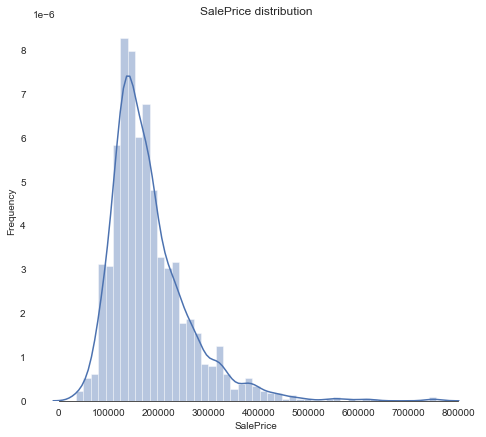

In [11]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train_df['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [12]:
train_df = train_df[train_df.GrLivArea < 4500]
train_df.reset_index(drop=True, inplace=True)

After Normalization


 mu = 12.02 and sigma = 0.40



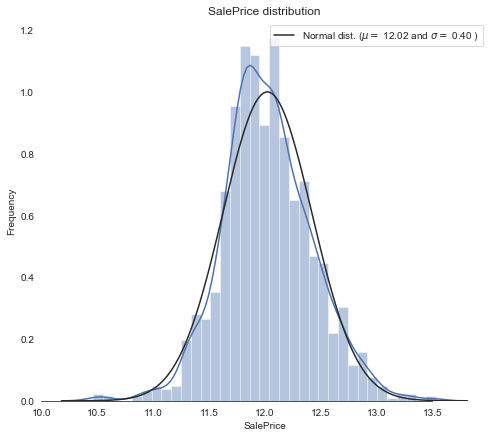

In [13]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mew, sigma) = norm.fit(train_df['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mew, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mew, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [14]:
target = train_df.SalePrice.reset_index(drop=True)
train_features = train_df.drop(['SalePrice'], axis=1)
test_features = test_df

# concatinate the train and the test set as features for tranformation to avoid mismatch
CombineFeatures = pd.concat([train_features, test_features]).reset_index(drop=True)
print('Features size:', CombineFeatures.shape)

Features size: (2917, 79)


In [15]:
def missing_percent(df):
    dff = pd.DataFrame(df)
    col_list = dff.columns.to_list()
    temp_dict = {}
    for i in range(0, len(col_list)):
        temp_dict.update({col_list[i]: round(dff[col_list[i]].isnull().mean()*100,2)})
    return temp_dict

In [16]:
missing = missing_percent(CombineFeatures)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:20]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45),
 ('GarageType', 5.38),
 ('BsmtCond', 2.81),
 ('BsmtExposure', 2.81),
 ('BsmtQual', 2.78),
 ('BsmtFinType2', 2.74),
 ('BsmtFinType1', 2.71),
 ('MasVnrType', 0.82),
 ('MasVnrArea', 0.79),
 ('MSZoning', 0.14),
 ('Utilities', 0.07)]

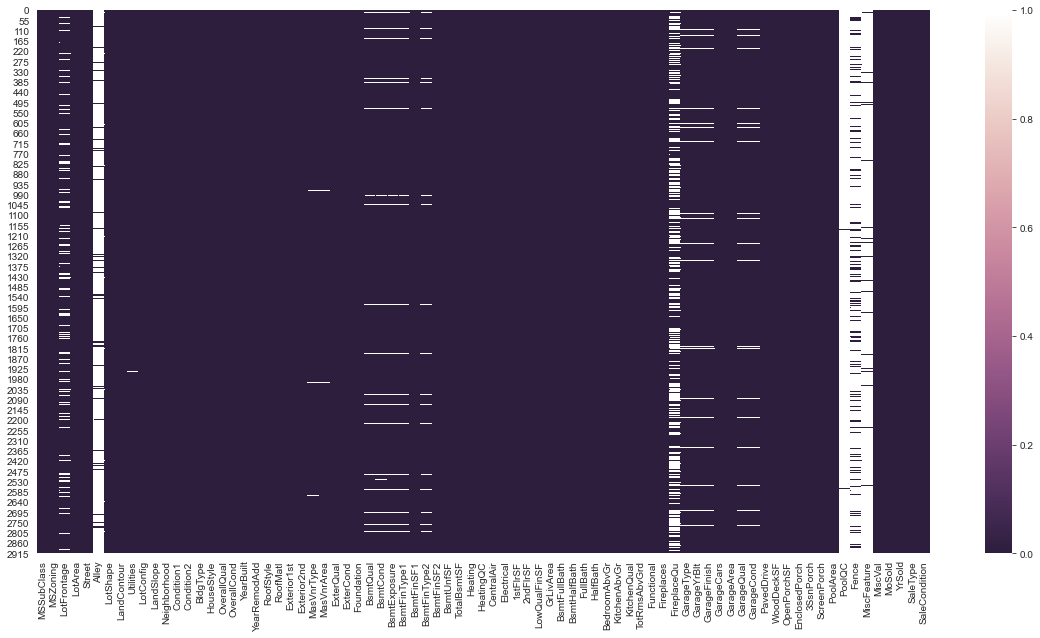

In [17]:
plt.figure(figsize=(20, 10))

# cubehelix palette is a part of seaborn that produces a colormap
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(CombineFeatures.isnull(), cmap=cmap)

In [18]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
CombineFeatures['MSSubClass'] = CombineFeatures['MSSubClass'].apply(str)
CombineFeatures['YrSold'] = CombineFeatures['YrSold'].astype(str)
CombineFeatures['MoSold'] = CombineFeatures['MoSold'].astype(str)

In [19]:
# data description says NA means typical
CombineFeatures['Functional'] = CombineFeatures['Functional'].fillna('Typ')
# has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
CombineFeatures['Electrical'] = CombineFeatures['Electrical'].fillna("SBrkr")
#  Only one NA value, We set 'TA' (which is the most frequent) for the missing value in KitchenQual
CombineFeatures['KitchenQual'] = CombineFeatures['KitchenQual'].fillna("TA")

In [20]:
# Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
CombineFeatures['Exterior1st'] = CombineFeatures['Exterior1st'].fillna(CombineFeatures['Exterior1st'].mode()[0])
CombineFeatures['Exterior2nd'] = CombineFeatures['Exterior2nd'].fillna(CombineFeatures['Exterior2nd'].mode()[0])
# Fill in again with most frequent
CombineFeatures['SaleType'] = CombineFeatures['SaleType'].fillna(CombineFeatures['SaleType'].mode()[0])

# data description says NA means "No Pool", majority of houses have no Pool at all in general.
CombineFeatures["PoolQC"] = CombineFeatures["PoolQC"].fillna("No_Pool")

In [21]:
# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    CombineFeatures[col] = CombineFeatures[col].fillna(0)
# Replacing missing data with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    CombineFeatures[col] = CombineFeatures[col].fillna('No_Garage')
# For all these categorical basement-related CombineFeatures, NaN means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    CombineFeatures[col] = CombineFeatures[col].fillna('No_Basement')

In [22]:
# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
CombineFeatures['MSZoning'] = CombineFeatures.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
CombineFeatures['LotFrontage'] = CombineFeatures.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [23]:
print('Features size:', CombineFeatures.shape)

Features size: (2917, 79)


In [24]:
# Filling the rest of the categorical features
object_list = []
for i in CombineFeatures.columns:
    if CombineFeatures[i].dtype == object:
        object_list.append(i)
CombineFeatures.update(CombineFeatures[object_list].fillna('None'))

In [25]:
# Filling in the rest of the NA's
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in CombineFeatures.columns:
    if CombineFeatures[i].dtype in numeric_dtypes:
        numerics.append(i)
CombineFeatures.update(CombineFeatures[numerics].fillna(0))

In [26]:
CombineFeatures.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

In [27]:
# First we need to find all numeric CombineFeatures in the data
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in CombineFeatures.columns:
    if CombineFeatures[i].dtype in numeric_dtypes:
        numerics2.append(i)

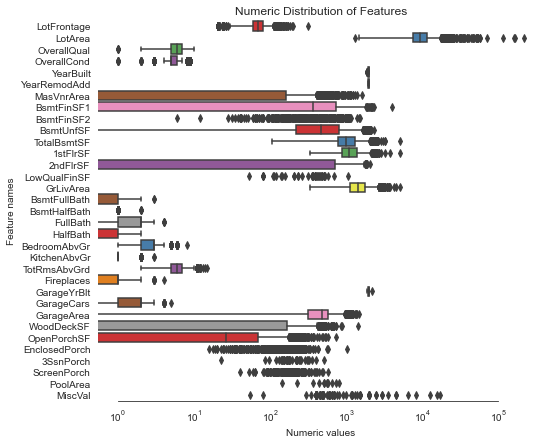

In [28]:
# Box plots for all our numeric CombineFeatures
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=CombineFeatures[numerics2] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [29]:
# Find the skewed  numerical CombineFeatures
skew_CombineFeatures = CombineFeatures[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_CombineFeatures[skew_CombineFeatures > 0.5]
skew_index = high_skew.index
print("There are {} numerical CombineFeatures with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_CombineFeatures.head(20)

There are 25 numerical CombineFeatures with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
dtype: float64

In [30]:
# Normalise skewed CombineFeatures
for i in skew_index:
    CombineFeatures[i] = boxcox1p(CombineFeatures[i], boxcox_normmax(CombineFeatures[i] + 1))

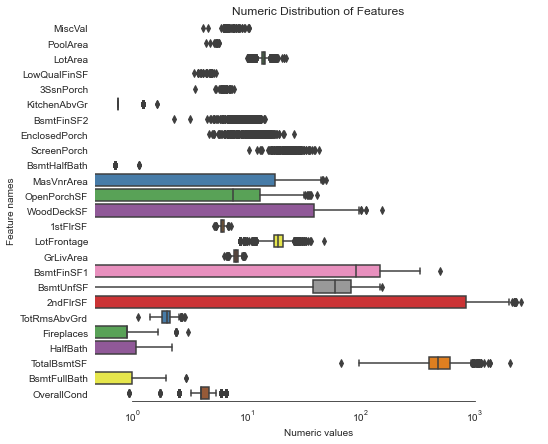

In [31]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=CombineFeatures[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [32]:
# Calculating totals before droping less significant columns

#  Adding total sqfootage feature 
CombineFeatures['TotalSF']=CombineFeatures['TotalBsmtSF'] + CombineFeatures['1stFlrSF'] + CombineFeatures['2ndFlrSF']
#  Adding total bathrooms feature
CombineFeatures['Total_Bathrooms'] = (CombineFeatures['FullBath'] + (0.5 * CombineFeatures['HalfBath']) +
                               CombineFeatures['BsmtFullBath'] + (0.5 * CombineFeatures['BsmtHalfBath']))
#  Adding total porch sqfootage feature
CombineFeatures['Total_porch_sf'] = (CombineFeatures['OpenPorchSF'] + CombineFeatures['3SsnPorch'] +
                              CombineFeatures['EnclosedPorch'] + CombineFeatures['ScreenPorch'] +
                              CombineFeatures['WoodDeckSF'])

In [33]:
# Not normaly distributed can not be normalised and has no central tendecy
CombineFeatures = CombineFeatures.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

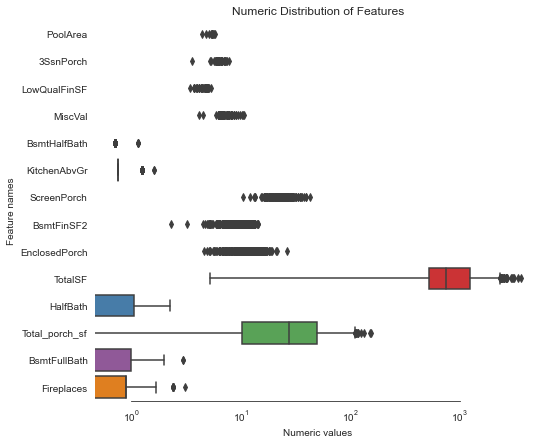

In [34]:
# Check the distribution after dopping the skewed CombineFeatures
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics3 = []
for i in CombineFeatures.columns:
    if CombineFeatures[i].dtype in numeric_dtypes:
        numerics3.append(i)
        
skew_CombineFeatures = CombineFeatures[numerics3].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_CombineFeatures[skew_CombineFeatures > 0.5]
skew_index = high_skew.index

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=CombineFeatures[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [35]:
# Adding new simplified CombineFeatures (1 = present, 0 = not present)
CombineFeatures['haspool'] = CombineFeatures['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
CombineFeatures['hasgarage'] = CombineFeatures['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
CombineFeatures['hasbsmt'] = CombineFeatures['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
CombineFeatures['hasfireplace'] = CombineFeatures['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print('Features size:', CombineFeatures.shape)

Features size: (2917, 81)


In [36]:
# Encoding the finalized CombineFeatures
final_CombineFeatures = pd.get_dummies(CombineFeatures).reset_index(drop=True)
print('Features size:', final_CombineFeatures.shape)

Features size: (2917, 334)


In [37]:
# Spliting the data back to train(X,y) and test(X_sub)
train = final_CombineFeatures.iloc[:len(target), :]
test = final_CombineFeatures.iloc[len(train):, :]
print('Features size for train(X,y) and test(X_test):')
print('train', train.shape, 'y', target.shape, 'test', test.shape)

Features size for train(X,y) and test(X_test):
train (1458, 334) y (1458,) test (1459, 334)


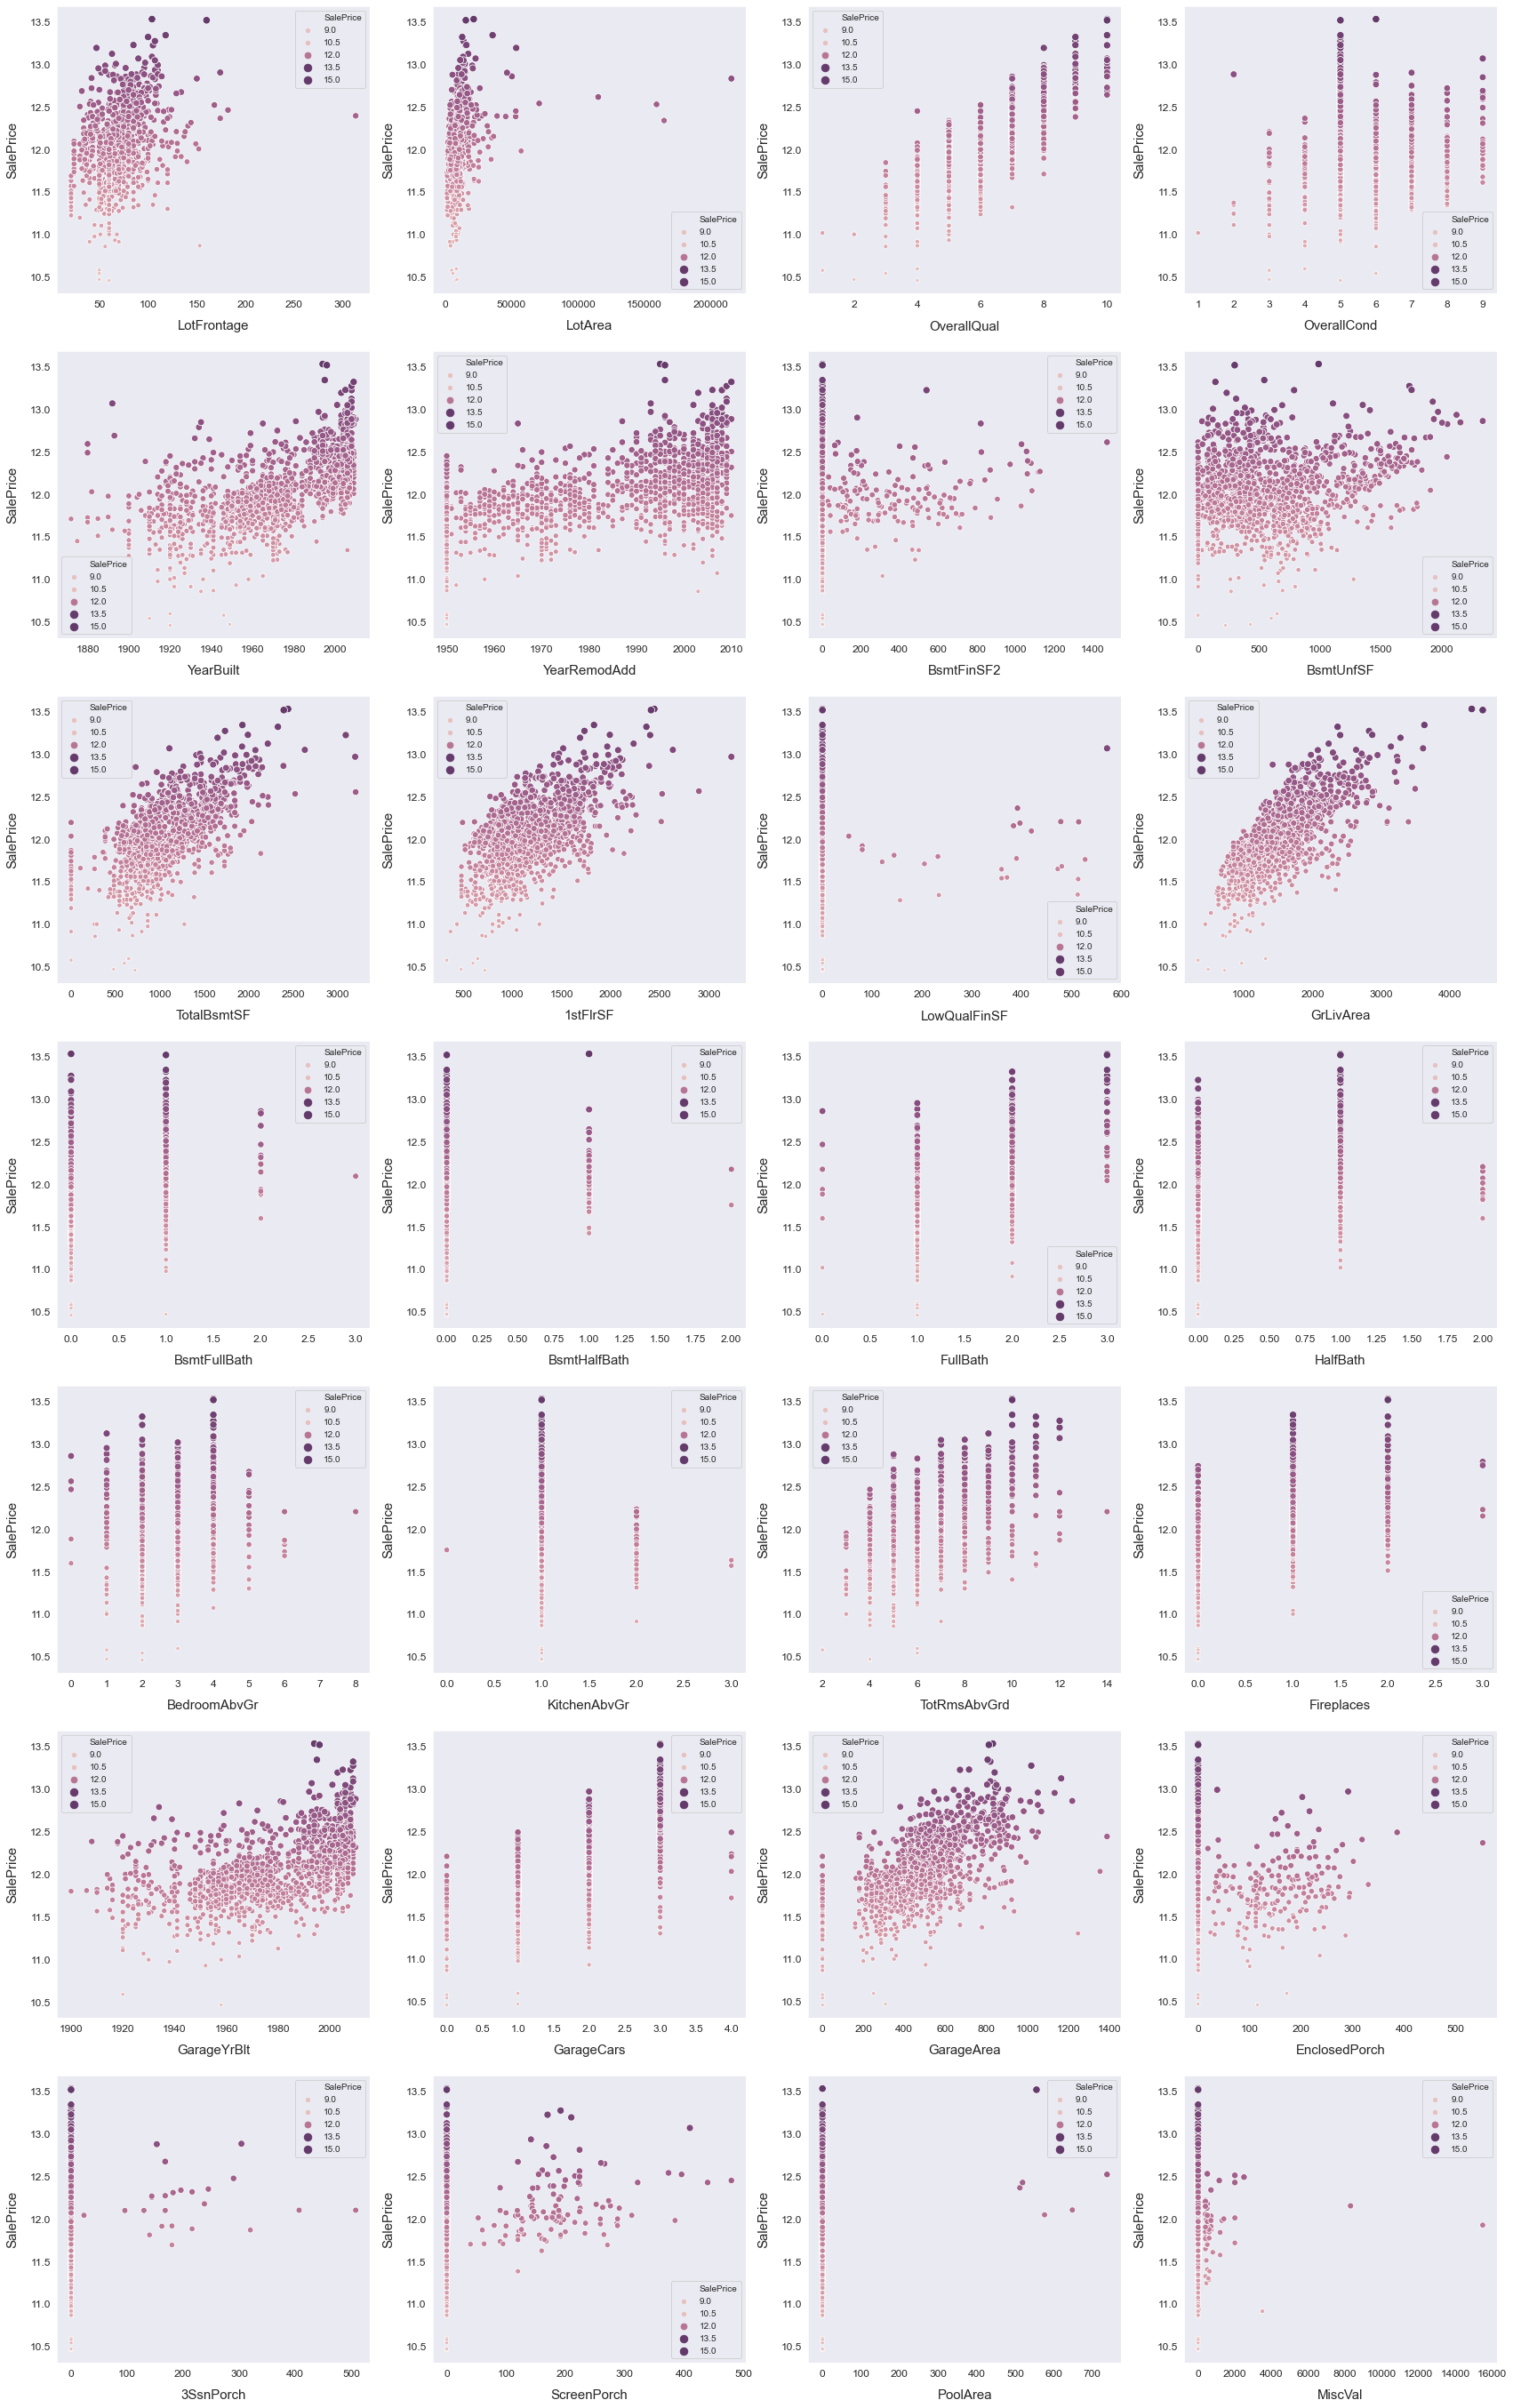

In [38]:
# Finding numeric CombineFeatures
sns.set_style("dark")
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics4 = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numerics4.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 80))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)
for i, feature in enumerate(list(train[numerics4]), 1):    
    plt.subplot(len(list(numerics4)), 4, i)
    sns.scatterplot(x=feature, y="SalePrice", hue="SalePrice", size="SalePrice", palette=cmap, data=train_df)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

In [39]:
# Removes outliers 
outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])
target = target.drop(target.index[outliers])

In [40]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
null_cols = []
for i in train.columns:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 99.95:
        null_cols.append(i)

null_cols = list(null_cols)
null_cols = null_cols + ["MSZoning_FV","MSZoning_RH"]

In [41]:
liste = ["MSZoning_FV","MSZoning_RH","MSZoning_RL","MSZoning_RM"]
for i in liste:
    print(train[i].value_counts())

0    1388
1      65
Name: MSZoning_FV, dtype: int64
0    1437
1      16
Name: MSZoning_RH, dtype: int64
1    1146
0     307
Name: MSZoning_RL, dtype: int64
0    1235
1     218
Name: MSZoning_RM, dtype: int64


In [42]:
train = train.drop(null_cols, axis=1).copy()
test = test.drop(null_cols, axis=1).copy()

print('Train', train.shape, 'Target', target.shape, 'test', test.shape)

Train (1453, 330) Target (1453,) test (1459, 330)


In [43]:
train.shape

(1453, 330)

In [44]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

In [45]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [46]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=train):
    rmse = np.sqrt(-cross_val_score(model, train, target,scoring="neg_mean_squared_error",cv=kfold))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [47]:
# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfold))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfold))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfold, l1_ratio=e_l1ratio))

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet}
predictions = {}
scores = {}

for name, model in models.items():
    
    model.fit(train, target)
    predictions[name] = np.expm1(model.predict(train))
    
    score = cv_rmse(model, X=train)
    scores[name] = (score.mean(), score.std())

In [48]:
# get the performance of each model on training data(validation set)
print('---- Score with CV_RMSLE-----')
score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

---- Score with CV_RMSLE-----
Ridge score: 0.1012 (0.0137)

Lasso score: 0.1001 (0.0140)

ElasticNet score: 0.1002 (0.0141)



In [49]:
#Fit the training data X, y
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(train, target)
print('Lasso')
lasso_model = lasso.fit(train, target)
print('Ridge')
ridge_model = ridge.fit(train, target)

----START Fit---- 2020-07-31 23:50:43.820348
Elasticnet
Lasso
Ridge


In [50]:
# model blending function using fitted models to make predictions
def blend_models(train):
    return ((elastic_model.predict(train)) + (lasso_model.predict(train)) + (ridge_model.predict(train)))/3
blended_score = rmsle(target, blend_models(train))
print('RMSLE score on train data:')
print(rmsle(target, blend_models(train)))

RMSLE score on train data:
0.08911063535305008


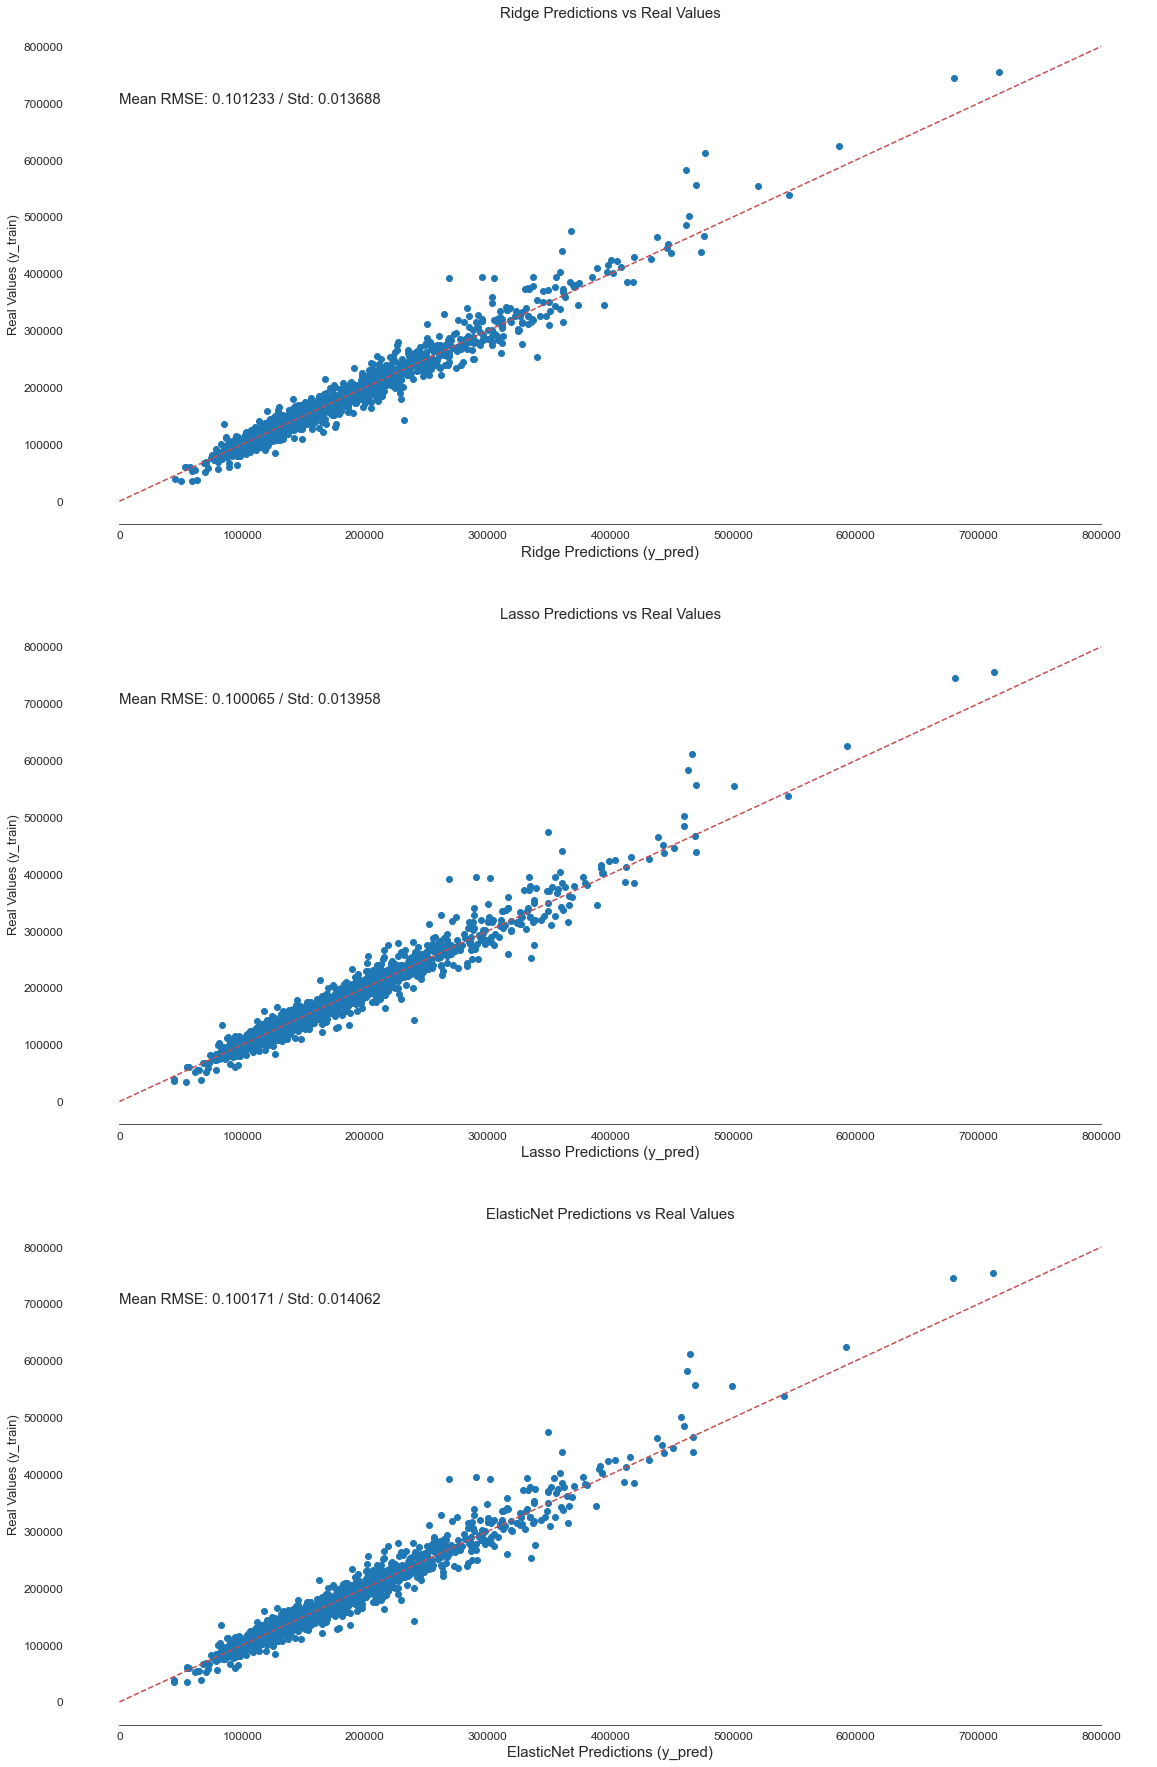

In [51]:
# visualise model performance
sns.set_style("white")
fig, axs = plt.subplots(ncols=0, nrows=3, figsize=(8, 7))
plt.subplots_adjust(top=3.5, right=2)

for i, model in enumerate(models, 1):
    plt.subplot(3, 1, i)
    plt.scatter(predictions[model], np.expm1(target))
    plt.plot([0, 800000], [0, 800000], '--r')

    plt.xlabel('{} Predictions (y_pred)'.format(model), size=15)
    plt.ylabel('Real Values (y_train)', size=13)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title('{} Predictions vs Real Values'.format(model), size=15)
    plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model][0], scores[model][1]), fontsize=15)
    ax.xaxis.grid(False)
    sns.despine(trim=True, left=True)
plt.show()

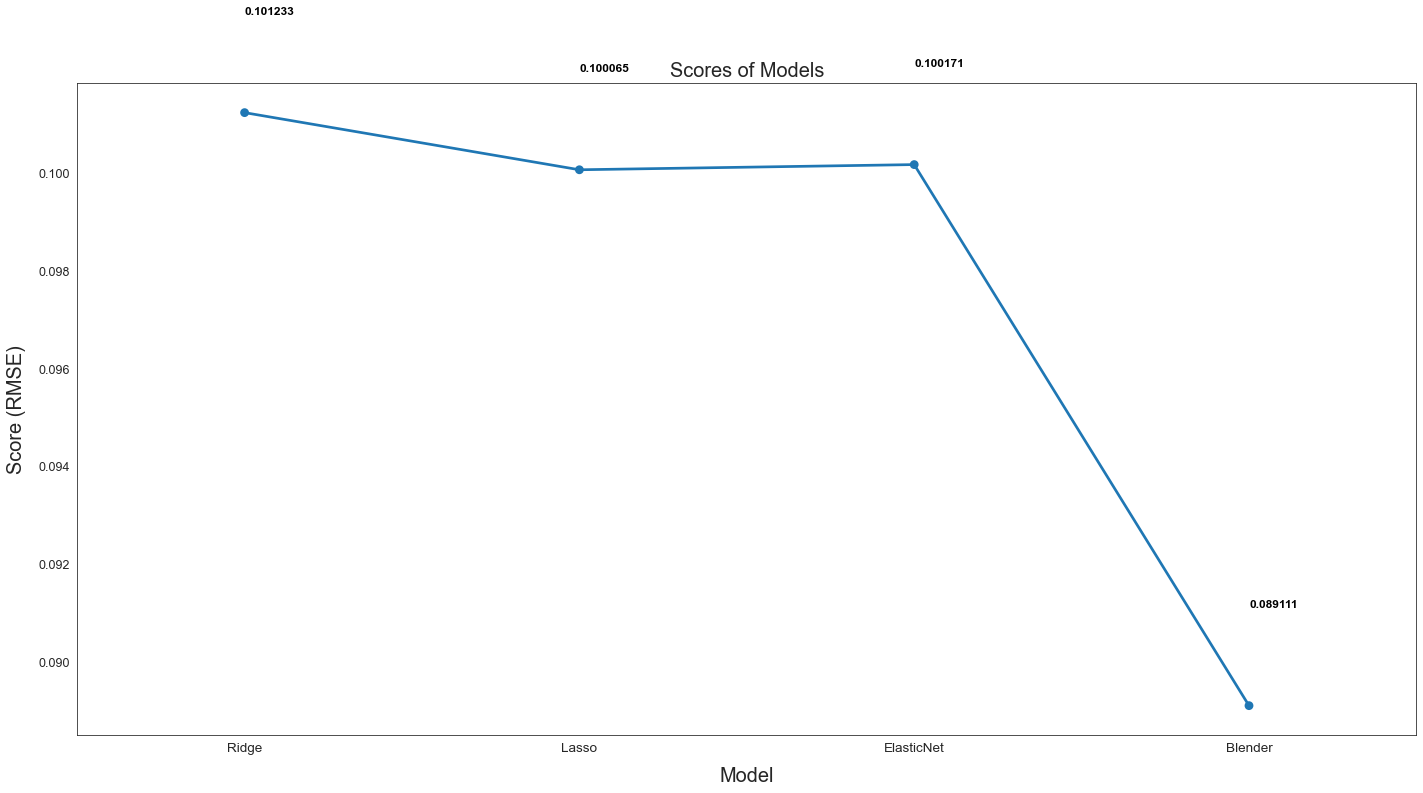

In [52]:
scores['Blender'] = (blended_score, 0)
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [53]:
# get the target variable/ y_test with X_test
print('Predict submission')
y_test_r = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
y_test = np.log1p(y_test_r.iloc[:,1].values)
submission.iloc[:,1] = np.expm1(blend_models(test))
blended_score = rmsle(y_test, blend_models(test))

Predict submission


In [54]:
submission.to_csv("submission.csv")

In [55]:
submission.shape

(1459, 2)